## Теоретическая часть


1. Ответьте на вопросы:  
В чем принципиальное отличие гибридных рекомендательных систем от коллаборативной филтьтрации?  
Приведите 2-3 примера задач, в которых необходимо использовать гибридные системы  




гибритные системы для прогнозирования используют параметры пользователя(товара)
в отличии от коллаборативной фильтрации которая использует только матрицу user_item и соответственно
её веса(факт покупки, стоимость, количество покупок)

примеры:
1) Мы знаем о пользователе его возраст, семейное положение, и допустим заранее интерес к категориям товаров(выбранных в приложении магазина). Тогда будем использовать гибридную систему, чтоб задействовать эту доп инфу о нем.

2) Мы поделили товары в магазине на категории, и еще на категории по цене(бюджетные, средние, премиальные). Тогда тоже будем использовать гибридную систему чтоб для нового пользователя(холодный старт), используя инфу что он добавил в корзину товар эконом класса, рекомендовать ему тоже эконом товары(то есть сипользовать фичи)

2.  Прочитайте статью про поиск на hh.ru https://habr.com/ru/company/hh/blog/347276/
Нам интересна именно рекомендательная система, раздел "Производительность системы" можно пропустить
Какие основные отличия предложенной системы от тех подходов, которые мы разбирали на семинарах? Какие проблемы могут возникнуть при выводе такой модели в продакшен?

Основное отличие что они использовали несколько моделей подряд (несколько фильтрирующих и потом ранжирующую)

3. На вебинаре мы рассматривали модель LightFM (https://making.lyst.com/lightfm/docs/lightfm.html). В работе Data Scientist'а важную часть занимает research - исследование существующих архитектур и разбор научных статей, в которых они описываются. Вам предлагается изчуть оригинальную статью про LightFM https://arxiv.org/pdf/1507.08439.pdf и ответить на следующие вопросы:  
1) Какой датасет используют авторы?  
2) Что используют в качестве признаков?  
3) С какими моделями сравнивают LightFM? Опишите их основные идеи кратко  

1) Они использовали 2 датасета  MovieLens и CrossValidated

2) Они использовали категории и подкатегории одежды и другие фичи сгенерированные другой ML моделью.

3) Они сравнивают lightfm с алгоритмом матричной факторизации, которая в свою очередь похожа на LFM но выигрывает за счет того что в отличие от LFM использует только 1 фичу(indicator feature) и из за этого не столь склонна к переобучению и намного эффективнее, но проблема что embedding(latent vector) не может быть посчитан для нового пользователя(холодный старт)

Soborof - представляют пользователей как линейные комбинации
векторов признаков элементов, с которыми они взаимодействовали.
Затем они выполняют LSI для полученной матрицы элементов-характеристик, чтобы получить embadding пользователей. Представления о новых
элементы получаются путем их проецирования на пространство скрытых признаков.

Saveski, McAuley - выполнить совместную факторизацию матриц useritem и item-feature, используя один и тот же скрытый элемент. Параметры оптимизированы путем минимизации взвешенной суммы reproduction loss обеих матриц.

Shmueli - представляют элементы как линейные комбинации скрытых факторов их характеристик, чтобы рекомендовать новостные статьи;
как и LightFM, они используют одноцелевой подход и минимизируют reproduction loss матрицы user-item.

## Практическая часть


In [374]:
import lightfm

In [375]:
# import data
# utils functions like in webinar

### 1. Модуль SRC

На вебинаре было рассказано про модуль src. Он приложен в материалах. Скачайте его, изучите структуру, импортируйте функции

In [376]:
import src_right.recommenders
import src_right.utils
import src_right.metrics

### 2. Работа с признаками

У нас есть внешние данные. Что с ними не так? Чего не хватает?  

Проведите исследование внешних данных и составьте какие-нибудь содержательные выводы.  
Формально Вам нужно построить 3+ графиков (scatter plot, hist или что-то иное) и описать, что мы видим (например, товары такой-то категории болле часто покупаются в следующие дни недели или пользователи с большим достатком предпочитают такие-то товары).  
Исследуйте те закономерности, которые Вам интересно, чем менее тривиальный вывод получается, тем лучше! 

In [377]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src_right.metrics import precision_at_k, recall_at_k
from src_right.utils import prefilter_items

In [378]:
data = pd.read_csv('../2_item_item_rec/data/retail_train.csv')
item_features = pd.read_csv('../2_item_item_rec/data/product.csv')
user_features = pd.read_csv('../2_item_item_rec/data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# train test split
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [236]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [237]:
user_features.user_id

0         1
1         7
2         8
3        13
4        16
       ... 
796    2494
797    2496
798    2497
799    2498
800    2499
Name: user_id, Length: 801, dtype: int64

In [238]:
data_item = data.join(item_features.set_index('item_id'), on='item_id', how='left')

In [239]:
department_item = data_item.groupby('department').agg({'item_id':'count'}).drop(index=' ')

In [85]:
department_item

,item_id
department,
AUTOMOTIVE,59
CHARITABLE CONT,2
CHEF SHOPPE,661
CNTRL/STORE SUP,21
COSMETICS,7083
COUP/STR & MFG,771
DAIRY DELI,53
DELI,58091
DELI/SNACK BAR,9


Можем заметить что кратно больше всех продается категория Grocery, можно предположить что будет лишним 
рекомендовать товары из данной категории пользователям, так как их и так купят.

In [100]:
data_item.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0,2,PRODUCE,National,ONIONS,ONIONS SWEET (BULK&BAG),40 LB
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0,69,PRODUCE,Private,VEGETABLES - ALL OTHERS,CELERY,
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0,2,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,69,PRODUCE,Private,ORGANICS FRUIT & VEGETABLES,ORGANIC CARROTS,1 LB


In [104]:
 data_item['day_of_week'] = data_item['day'] - (data_item['day'] // 7) * 7

In [102]:
import seaborn as sns

In [131]:
department_day = data_item.groupby(['day_of_week', 'department'], as_index=False).agg({'quantity':'sum'})

department_day.head()

,day_of_week,department,quantity
0,0,,0
1,0,AUTOMOTIVE,4
2,0,CHARITABLE CONT,2
3,0,CHEF SHOPPE,92
4,0,CNTRL/STORE SUP,2


<AxesSubplot:xlabel='day_of_week', ylabel='quantity'>

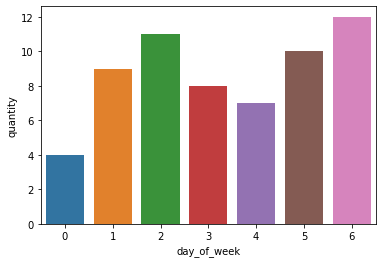

In [147]:
sns.barplot(x="day_of_week", y="quantity", data=department_day.loc[department_day['department']=='AUTOMOTIVE'])

Можем сделать выдвинуть гипотезу о том что в 0-вой день недели люди не склонны покупать товары данной категории. Если результат окажется статистически значимым не будем рекомендовать данные товары в этот день.

In [154]:
data_brand_index = data_item.groupby(['brand', 'department'], as_index=False)\
    .agg({'quantity':'sum'})

In [151]:
data_brand_index.loc[data_brand_index['department'] == 'AUTOMOTIVE']

,brand,department,quantity
1,National,AUTOMOTIVE,1
43,Private,AUTOMOTIVE,60


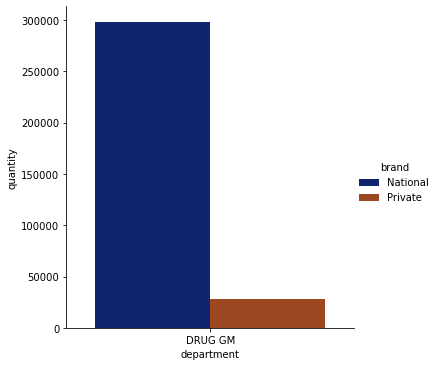

In [155]:
sns.catplot(
    data=data_brand_index.loc[data_brand_index['department'] == 'DRUG GM'], kind="bar",
    x="department", y="quantity", hue="brand",
    palette="dark"
)

### Сделаем вывод что люди больше доверяют государственным компаниям, в вопросе лекарств и будем рекомендовать их

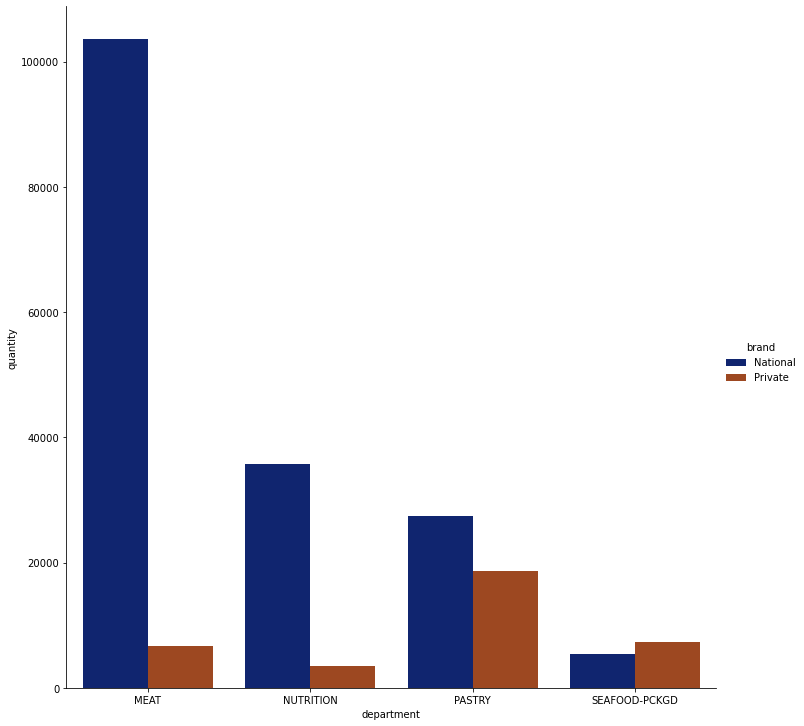

In [177]:
sns.catplot(
    data=data_brand_index.loc[data_brand_index['department']\
    .isin(['SEAFOOD-PCKGD','MEAT','NUTRITION','PASTRY'])], kind="bar",
    x="department", y="quantity", hue="brand",
    palette="dark", height=10)


На категориях мясо и Nutrition предпочтительнее национальная продукция

### 3. LightFM

У этого алогритма есть множество параметров (item/user_alpha, loss, no_components).  
Проведите эксперименты аналогично дз 3 (подберите гипперпараметры каким удобно способои и постройте графики)  
На выходе необходимо получить pr@5 на валидации (последние 3 недели) > 17%  

У Вас, скорее всего, возникнет проблема со временем обучения. Почему они возникает?    

Попробуйте запустить алгоритм вообще без фичей или используйте только признаки с небольшим числом уникальных категорий. (item_features['commodity_desc'].unique() - 300 уникальных категорий - это очень много)

#У Вас, скорее всего, возникнет проблема со временем обучения. Почему они возникает?    

Потому что слишком много фичь, и для всех них создаются эмбединги.

In [393]:
import lightfm.evaluation
pr = lightfm.evaluation.precision_at_k

In [379]:
n_items_before = data_train['item_id'].nunique()

data_train = prefilter_items(data_train)

n_items_after = data_train['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 86865 to 5001


In [380]:
~data_test['item_id'].isin(data_train['item_id'].values)

2277416     True
2277417     True
2277418     True
2277419     True
2277420    False
           ...  
2396799     True
2396800     True
2396801     True
2396802     True
2396803     True
Name: item_id, Length: 118314, dtype: bool

In [381]:
data_test['item_id'].loc[~data_test['item_id'].isin(data_train['item_id'].values)] = 999999

/Users/maximcucer/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-381-c717ef0424d1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['item_id'].loc[~data_test['item_id'].isin(data_train['item_id'].values)] = 999999


In [382]:
set(data_test['item_id']).issubset(data_train['item_id'])

True

In [383]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(2)

item_id,117847,279994,818981,819255,819308,819400,819487,819590,819594,819840,...,15926775,15926844,15926886,15972074,15972298,15972565,15972790,16100266,16729299,16729415
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [384]:
test_user_item_matrix = pd.pivot_table(data_test, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

test_user_item_matrix = test_user_item_matrix.astype(float)
sparse_user_item_test = csr_matrix(test_user_item_matrix).tocsr()

In [385]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [386]:
user_feat = pd.DataFrame(user_item_matrix.index)
user_feat = user_feat.merge(user_features, on='user_id', how='left')
user_feat.set_index('user_id', inplace=True)

item_feat = pd.DataFrame(user_item_matrix.columns)
item_feat = item_feat.merge(item_features, on='item_id', how='left')
item_feat.set_index('item_id', inplace=True)

user_feat.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
user_id,,,,,,,
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [387]:
user_feat_lightfm = pd.get_dummies(user_feat, columns=user_feat.columns.tolist())
item_feat_lightfm = pd.get_dummies(item_feat, columns=item_feat.columns.tolist())

In [388]:
model = LightFM(no_components=10,
                    loss='bpr',
                    learning_rate=0.01, 
                    item_alpha=0.1, user_alpha=0.1, 
                    random_state=42)

In [389]:
model.fit(sparse_user_item,
                  sample_weight=coo_matrix(user_item_matrix),
                  user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                  item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                  epochs=15, 
                  num_threads=4)

In [362]:
%%time

results = []

for loss in ['bpr', 'warp']:
    for no_components in range(15, 115, 10):
        for learning_rate in [0.005, 0.01, 0.05]:
            model = LightFM(no_components=no_components,
                    loss=loss,
                    learning_rate=learning_rate, 
                    item_alpha=0.1, user_alpha=0.1, 
                    random_state=42)

            model.fit(sparse_user_item,
                  sample_weight=coo_matrix(user_item_matrix),
                  user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                  item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                  epochs=15, 
                  num_threads=4)

            prec = pr(model, sparse_user_item_test, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()
            
        
            results.append([loss, no_components, learning_rate, prec])

CPU times: user 41min 13s, sys: 25 s, total: 41min 38s
Wall time: 16h 52min 38s


In [363]:
results = np.array(results)

In [364]:
results_df = pd.DataFrame(results, columns=['loss', 'no_components', 'learning_rate', 'precision@5'])

In [391]:
user_biases_emb = model.get_user_representations(
    features=csr_matrix(user_feat_lightfm.values).tocsr()
)

In [392]:
item_emb = model.get_item_representations(
    features=csr_matrix(item_feat_lightfm.values).tocsr())

In [451]:
model = LightFM(no_components=35,
                    loss='warp',
                    learning_rate=0.05, 
                    item_alpha=1, user_alpha=1, 
                    random_state=42)

model.fit(sparse_user_item,
                  sample_weight=coo_matrix(user_item_matrix),
                  user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                  item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                  epochs=15, 
                  num_threads=4)

In [452]:
pr(model, sparse_user_item, 
                    user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                    item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                    k=5).mean()

0.29002807

In [423]:
test_precision = pr(model, sparse_user_item_test, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

In [424]:
test_precision

0.01410382

не смог лучше качество вытянуть, не понимаю в чем ошибка

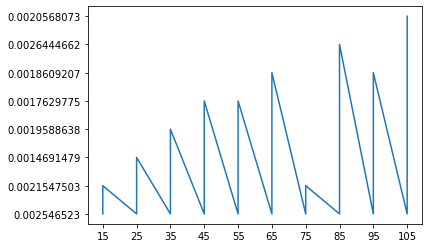

In [429]:
plt.plot(results_df['no_components'].loc[results_df['loss']=='bpr'], results_df['precision@5'].loc[results_df['loss']=='bpr'])

график растет, но скачет в моментах из за сменающегося lerning_rate

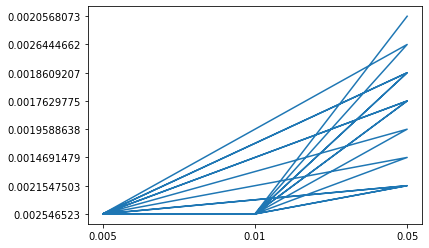

In [436]:
plt.plot(results_df['learning_rate']\
         .loc[results_df['loss']=='bpr'],\
         results_df['precision@5'].loc[results_df['loss']=='bpr'])


тоже отбросив остальные факторы, 0.05 learning rate показывает себя в среднем лучше

In [448]:
model = LightFM(no_components=35,
                    loss='warp',
                    learning_rate=0.05, 
                    item_alpha=1, user_alpha=1, 
                    random_state=42)

model.fit(sparse_user_item,
                  epochs=15, 
                  num_threads=4)

In [450]:
pr(model, sparse_user_item, user_features=None, item_features=None, k=5).mean()

0.011774129

результат хуже чем с фичами, но время обучение значительно снизилось